####  🍁Check Versions

In [2]:
# !python --version
import cupy as cp
cp.__version__

'13.3.0'

#### 🍁 Create Directory

In [3]:
import os

models_dir = "/kaggle/working/models/"

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

### 🍁 Preprocessing

In [5]:
# Import
from keras.datasets import mnist
(x_train, y_train), (_, _) = mnist.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

#1 Flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(f"x_train_flat shape: {x_train_flat.shape}, y_train shape: {y_train.shape}")

#2 Subsets
subset_size = 10000
x_train_subset = x_train_flat[:subset_size]
y_train_subset = y_train[:subset_size]
print(f"x_train_subset shape: {x_train_subset.shape}")

#3 PCA
from sklearn.decomposition import PCA
import numpy as np
n_components = 155
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_subset)
print(f"x_train_pca shape: ", x_train_pca.shape)
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance =", variance)

#4 Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_norm = scaler.fit_transform(x_train_pca)
print(f"x_train_norm shape: {x_train_norm.shape}")

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_train_flat shape: (60000, 784), y_train shape: (60000,)
x_train_subset shape: (10000, 784)
x_train_pca shape:  (10000, 155)
variance = 0.9519028045131284
x_train_norm shape: (10000, 155)


### [Training]

In [5]:
import pickle
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import itertools

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary):
    # num_data_points = x_train_norm.shape[0]
    # num_coefficients = n_components + 1  # (+1 for the first constant terms α0 & β0)
    # delta = 1e-6  # a small positive value

    # # Construct G(x) and H(x) matrices for numerator and denominator
    # G = cp.zeros((num_data_points, num_coefficients))  # Numerator matrix
    # H = cp.zeros((num_data_points, num_coefficients))  # Denominator matrix

    # for i in range(num_data_points):
    #   G[i, 0] = 1
    #   H[i, 0] = 1
    #   for j in range(num_coefficients-1):
    #     G[i, j+1] = x_train_norm[i, j] ** (j+1)
    #     H[i, j+1] = x_train_norm[i, j] ** (j+1)

    print(f"G: {G}")
    print(f"G.shape =", G.shape)
    print(f"H: {H}")

    -----------------------------------------
    def construct_G_H_matrices(x_train_norm, n, d):
      import itertools
      num_data_points = x_train_norm.shape[0]
    
      # Generate multi-indices
      multi_indices = [idx for idx in itertools.product(range(d + 1), repeat=n) if sum(idx) <= d]
      num_coefficients = len(multi_indices)
    
      # Initialize G and H matrices
      G = cp.zeros((num_data_points, num_coefficients))  # Numerator
      H = cp.zeros((num_data_points, num_coefficients))  # Denominator
    
      # Construct G and H using multi-indices
      for i in range(num_data_points):
          for j, idx in enumerate(multi_indices):
              term = cp.prod(cp.array([x_train_norm[i, k] ** idx[k] for k in range(n)]))
              G[i, j] = term
              H[i, j] = term  # G and H share the same multi-index logic
      return G, H, multi_indices
    
    def generate_multi_indices(n, d):
        indices = [idx for idx in itertools.product(range(d + 1), repeat=n) if sum(idx) <= d]
        return indices

    num_data_points = x_train_norm.shape[0]
    indices = generate_multi_indices(2, 2)
    
    num_coefficients = len(indices)
    
    G, H, multi_indices = construct_G_H_matrices(x_train_norm, 2, 2)
    
    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_binary[i] + z  # Upper bound
        f_minus_z = y_binary[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) + (-1).(f(xi) + z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficient of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem (methods: highs, revised simplex)
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_train_norm, y_binary, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_train_norm, y_binary)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Train a classifier for each digit
for digit in range(10):
    print(f"Training classifier for digit {digit}...")

    # Assign labels: Positive for the current digit, negative for others
    # y_binary = (y_train_subset == digit).astype(int)
    y_binary = (y_train_subset == digit).astype(float)

    # Scale binary labels to larger values
    # Positive class = 2, Negative class = 4
    y_binary = np.where(y_binary == 1, 2, 4)

    # print(f"y_binary =", y_binary)
    # print(f"y_train_subset =", y_train_subset)

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 500  # Initial upper bound
    precision = 1e-6 # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_train_norm, y_binary, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    # print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")
    
    # print(f"rational_function =", rational_function(x_train_norm[0], optimal_alpha, optimal_beta))

    # Save the model
    model = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "n_components": n_components
    }

    with open(f"{models_dir}classifier_{digit}.pkl", "wb") as file:
        pickle.dump(model, file)

    print(f"Model for digit {digit} saved at {models_dir}")

Training classifier for digit 0...
Number of Iterations: 29
Optimal z (Maximum Deviation): 9.313225746154785e-07
Optimized Coefficients (Numerator α): [ 3.00002159e-06  0.00000000e+00 -9.96521586e-11 -3.34030364e-11
 -1.44510579e-09  4.79731742e-10 -1.72602849e-09  1.75565826e-09
  1.83859318e-09  3.66987485e-10  3.91819214e-09  1.68089594e-08
  1.42920392e-08  2.06535375e-08 -2.15240891e-08 -5.10973107e-10
 -3.88094811e-08 -2.01152272e-11 -4.73088224e-10  0.00000000e+00
 -6.31924214e-08 -4.61692581e-08  4.15918334e-08  2.70774839e-06
  2.00106699e-06  3.90703829e-10  2.29796532e-09  4.95958816e-09
 -2.21962194e-08  0.00000000e+00  4.93216235e-08 -4.82370374e-09
 -4.35328448e-08 -1.00881166e-08 -1.82066371e-09  5.83804754e-09
  2.00008302e-06  4.77620472e-07 -1.70605995e-06 -1.01739966e-08
  1.57372787e-08 -9.65484388e-10  1.99803424e-06 -1.68558622e-09
  0.00000000e+00  1.99346979e-06  1.99962907e-06 -1.93751317e-09
  1.79944502e-07  7.42606655e-08 -2.81989959e-09  2.95529880e-09
  1.

### [Testing]

x_test shape: (10000, 28, 28), y_test shape: (10000,)
x_test shape: (10000, 784), y_test shape: (10000,)
x_test_subset shape: (10000, 784)
x_test_pca shape:  (10000, 77)
x_test_norm shape: (10000, 77)
Accuracy for digit 0: 54.15%
Accuracy for digit 1: 52.27%
Accuracy for digit 2: 89.68%
Accuracy for digit 3: 40.55%
Accuracy for digit 4: 40.93%
Accuracy for digit 5: 53.67%
Accuracy for digit 6: 51.71%
Accuracy for digit 7: 45.45%
Accuracy for digit 8: 47.92%
Accuracy for digit 9: 54.18%
Overall Accuracy: 53.05%


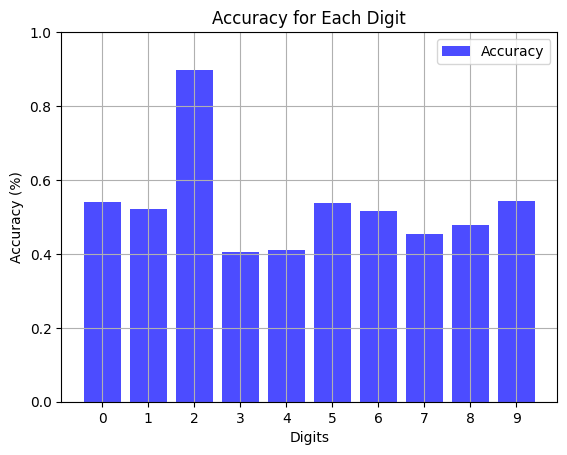

In [6]:
import cupy as cp
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt

# Define the rational function
# (α_0 + α_1*x1**1 + α_2*x2**2 + ...)
def rational_function(x, alpha, beta):
    numerator = alpha[0] + sum(alpha[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    denominator = beta[0] + sum(beta[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    return numerator / denominator

#-----------------------------------------------------
# import itertools

# def generate_multi_indices(n, d):
#     indices = [idx for idx in itertools.product(range(d + 1), repeat=n) if sum(idx) <= d]
#     return indices

# def construct_polynomial(x, coefficients, indices):
#     polynomial_value = 0
#     for coeff, idx in zip(coefficients, indices):
#         term = coeff * np.prod([x[i] ** idx[i] for i in range(len(x))])
#         polynomial_value += term
#     return polynomial_value

# def rational_function(x, alpha, beta, n, d):
#     indices = generate_multi_indices(n, d)

#     # Compute numerator and denominator
#     numerator = construct_polynomial(x, alpha, indices)
#     denominator = construct_polynomial(x, beta, indices)

#     # # Avoid division by zero
#     # if np.abs(denominator) < 1e-8:
#     #     denominator = 1e-8

#     return numerator / denominator

#-----------------------------------------------------
# Import
from keras.datasets import mnist
(_, _), (x_test, y_test) = mnist.load_data()
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#1 Flatten
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#2 Subsets
subset_size = 10000
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"x_test_subset shape: {x_test_subset.shape}")

#3 PCA
from sklearn.decomposition import PCA
import pickle
n_components = 77
pca = PCA(n_components=n_components)
x_test_pca = pca.fit_transform(x_test_subset)
print(f"x_test_pca shape: ", x_test_pca.shape)

#4 Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_norm = scaler.fit_transform(x_test_pca)
print(f"x_test_norm shape: {x_test_norm.shape}")

#------------------------------------------
# Load the saved models and test
models_dir = "/kaggle/working/models/"
accuracies = []

#------------------------------------------
for digit in range(10):
    # Load model for each digit
    with open(f"{models_dir}classifier_{digit}.pkl", "rb") as file:
        model = pickle.load(file)

    alpha = model["alpha"]
    beta = model["beta"]
    theta = model["theta"]

    # n = 2
    # d = 2
    # # Evaluate the rational function for each test data point
    # y_predicted = [
    #     rational_function(x, alpha, beta, n, d) for x in x_test_norm
    # ]

    y_predicted = [
    rational_function(x, alpha, beta) for x in x_test_norm
    ]

    # Convert predictions to binary (higher digit - for this digit, 0/lower digit for others)
    y_pred_binary = np.array(y_predicted) < 3
    y_true_binary = y_test_subset == digit

    # Calculate accuracy for this digit
    accuracy = np.mean(y_pred_binary == y_true_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for digit {digit}: {accuracy*100:.2f}%")

#------------------------------------------
# Calculate and print overall accuracy
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")

#------------------------------------------
# Plotting accuracies for each digit
plt.bar(range(10), accuracies, color='blue', alpha=0.7, label="Accuracy")
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy for Each Digit")
plt.xticks(range(10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# print(f"y_pred_binary =", y_pred_binary)
# print(f"y_true_binary =", y_true_binary)

# print(f"y_pred_binary.shape =", y_pred_binary.shape)
# print(f"y_true_binary.shape =", y_true_binary.shape)

In [ ]:
import time
start_time = time.time()

end_time = time.time()
print("runing time:{} s".format(end_time - start_time))